In [17]:
from keras.datasets import cifar10
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.models import Sequential
import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras.models import Model
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LeakyReLU, LSTM, UpSampling2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
tfkl = tfk.layers

# Autoencoder

In [10]:
# load data
(trainX, trainY), (testX, testY)=cifar10.load_data()
# view the  data shape
trainX.shape

(50000, 32, 32, 3)

In [11]:
trainY.shape

(50000, 1)

In [12]:
testX.shape

(10000, 32, 32, 3)

In [13]:
testY.shape

(10000, 1)

In [14]:
trainX=trainX.astype('float32')/255.0
testX=testX.astype('float32')/255.0

In [21]:
# train
input_img=Input(shape=(32,32,3))

conv = Conv2D(filters=32, kernel_size=(3,3),padding="same", activation='relu')(input_img)
conv = MaxPooling2D((2, 2), padding='same')(conv)

conv = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(conv)
conv = MaxPooling2D((2, 2), padding='same')(conv)

conv = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(conv)
encoded = MaxPooling2D((2, 2), padding='same')(conv)

conv = Conv2D(8, kernel_size =  (3, 3), activation='relu', padding='same')(encoded)
conv = UpSampling2D((2, 2))(conv)

conv = Conv2D(8, kernel_size = (3, 3), activation='relu', padding='same')(conv)
conv = UpSampling2D((2, 2))(conv)

conv = Conv2D(32, kernel_size = (3, 3), activation='relu',padding='same')(conv)
conv = UpSampling2D((2, 2))(conv)

output = Conv2D(3, kernel_size = (3, 3), activation='relu', padding='same')(conv)


autoencoder = Model(input_img, output)
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         2312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)          

In [22]:
autoencoder.fit(trainX, trainX,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(testX, testX))

Epoch 1/10
391/391 [==============================] - 54s 139ms/step - loss: 0.0348 - accuracy: 0.4146 - val_loss: 0.0203 - val_accuracy: 0.4398
Epoch 2/10
391/391 [==============================] - 54s 137ms/step - loss: 0.0189 - accuracy: 0.4780 - val_loss: 0.0169 - val_accuracy: 0.5869
Epoch 3/10
391/391 [==============================] - 54s 137ms/step - loss: 0.0159 - accuracy: 0.6025 - val_loss: 0.0152 - val_accuracy: 0.6247
Epoch 4/10
391/391 [==============================] - 54s 138ms/step - loss: 0.0149 - accuracy: 0.6188 - val_loss: 0.0147 - val_accuracy: 0.6257
Epoch 5/10
391/391 [==============================] - 53s 136ms/step - loss: 0.0143 - accuracy: 0.6256 - val_loss: 0.0140 - val_accuracy: 0.6313
Epoch 6/10
391/391 [==============================] - 53s 136ms/step - loss: 0.0138 - accuracy: 0.6308 - val_loss: 0.0137 - val_accuracy: 0.6303
Epoch 7/10
391/391 [==============================] - 54s 138ms/step - loss: 0.0135 - accuracy: 0.6342 - val_loss: 0.0134 - val_ac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


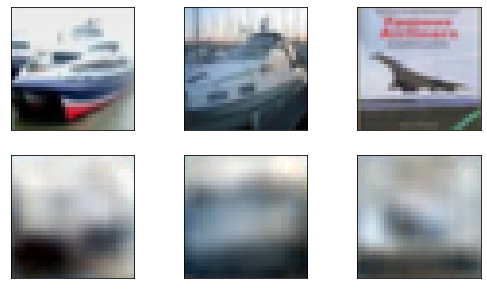

In [32]:
# compare before and after
output_imgs = autoencoder.predict(testX)
plt.figure(figsize=(15, 5))
for i in range(1,4):
    # befor
    ax = plt.subplot(2, 5, i)
    plt.imshow(testX[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # after
    ax = plt.subplot(2, 5, i + 5)
    plt.imshow(output_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# CNN

In [34]:
# deep CNN
data, info = tfds.load('cifar10', with_info=True)
process = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

# normalize
ds_train = data["train"].map(process).cache().batch(32)
ds_test = data["test"].map(process).cache().batch(32)

deep_cnn = tfk.Sequential([
  # relu activation function
  tfkl.Conv2D(filters = 128,kernel_size=(3,3),strides=1, activation=tf.nn.relu,padding="same",input_shape=(32,32,3)), tfkl.MaxPooling2D(pool_size=3,padding="same"),
  tfkl.Conv2D(64,kernel_size=(2,2), activation=tf.nn.relu,padding="same"), tfkl.MaxPooling2D(pool_size=2,padding="same"),
  tfkl.Conv2D(32,kernel_size=(2,2), activation=tf.nn.relu,padding="same"),tfkl.MaxPooling2D(pool_size=2,padding="same"),
  tfkl.Dropout(0.3), tfkl.Dense(64,activation="sigmoid"),
  tfkl.Flatten(), tfkl.Dense(10,activation="softmax")
])

deep_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 32)          8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0

In [35]:
deep_cnn.compile(
    optimizer = tfk.optimizers.RMSprop(), loss = tfk.losses.CategoricalCrossentropy()
)

In [36]:
results = deep_cnn.fit(ds_train,steps_per_epoch=50,epochs=10,batch_size = 10,validation_data = ds_test)

Epoch 1/10
50/50 [==============================] - 5s 93ms/step - loss: 2.3557 - val_loss: 2.3240
Epoch 2/10
50/50 [==============================] - 4s 83ms/step - loss: 2.2790 - val_loss: 2.1867
Epoch 3/10
50/50 [==============================] - 4s 84ms/step - loss: 2.1848 - val_loss: 2.0912
Epoch 4/10
50/50 [==============================] - 4s 84ms/step - loss: 2.1203 - val_loss: 2.0658
Epoch 5/10
50/50 [==============================] - 4s 84ms/step - loss: 2.1057 - val_loss: 2.0309
Epoch 6/10
50/50 [==============================] - 4s 84ms/step - loss: 2.0636 - val_loss: 1.9603
Epoch 7/10
50/50 [==============================] - 4s 84ms/step - loss: 2.0494 - val_loss: 1.9199
Epoch 8/10
50/50 [==============================] - 4s 84ms/step - loss: 1.9663 - val_loss: 1.8970
Epoch 9/10
50/50 [==============================] - 4s 85ms/step - loss: 1.9090 - val_loss: 1.8011
Epoch 10/10
50/50 [==============================] - 4s 85ms/step - loss: 1.8909 - val_loss: 1.8810


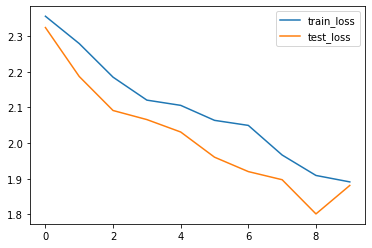

In [37]:
# plot loss and val loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['train_loss','test_loss'])

In [38]:
# transfer  learning
conv = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

transfer_model = tfk.Sequential([
  # convolution
  conv,
  # decrease dimension
  tfkl.GlobalMaxPool2D(),
    # condense
  tfkl.Dense(64,activation='relu'),
  # avoid overfitting
  tfkl.Dropout(0.3),
  tfkl.Dense(10,activation='softmax')                                
])

transfer_model.summary()

58892288/58889256 [==============================] - 10s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 14,748,170
Non-trainable params: 0
_________________________________________________________________


In [39]:
# same process as before
transfer_model.compile(optimizer = tfk.optimizers.RMSprop(),loss = tfk.losses.CategoricalCrossentropy())
conv.trainable = False
results = transfer_model.fit(ds_train, 
                             steps_per_epoch = 20,
                             epochs=5, 
                             batch_size = 10,
                             validation_data = ds_test)

Epoch 1/5
20/20 [==============================] - 34s 2s/step - loss: 90.5365 - val_loss: 2.3143
Epoch 2/5
20/20 [==============================] - 33s 2s/step - loss: 2.3192 - val_loss: 2.4418
Epoch 3/5
20/20 [==============================] - 32s 2s/step - loss: 2.3360 - val_loss: 2.3026
Epoch 4/5
20/20 [==============================] - 32s 2s/step - loss: 2.3028 - val_loss: 2.3026
Epoch 5/5
20/20 [==============================] - 32s 2s/step - loss: 2.3028 - val_loss: 2.3026


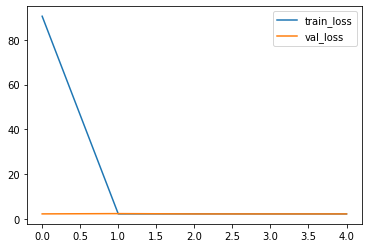

In [42]:
# plot loss and val loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['train_loss','val_loss'])

# Text Classification

In [43]:
# load data 
data=pd.read_csv('SPAM_detection.csv')
data.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [45]:
# data process
# transform to lower case
data['Message'] = data['Message'].str.lower()
text = data['Message'].values
val = data['category_val'].values
# transform to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
text = tokenizer.texts_to_sequences(text)
text = sequence.pad_sequences(text)

In [47]:
# view shape
text.shape

(5572, 189)

In [48]:
val.shape

(5572,)

In [55]:
import random
# split randomly
trainX,testX,trainY,testY = train_test_split(text,
                                                val,
                                                test_size=0.3,
                                                random_state=random.randint(0,50))

In [56]:
# view shape
trainX.shape

(3900, 189)

In [57]:
testX.shape

(1672, 189)

In [58]:
# RNN
text_model_rnn = tfk.Sequential([
  tfkl.Embedding(len(tokenizer.word_index)+1,10,input_length=trainX.shape[1]),
  # LSTM
  tfkl.LSTM(64,return_sequences=True),
  # decrease dimension
  tfkl.GlobalMaxPool1D(),
  tfkl.Dropout(0.3),
  tfkl.Dense(1,activation='sigmoid')                                
])

# binary_crossentropy
text_model_rnn.compile(optimizer = tfk.optimizers.RMSprop(),
                   loss = 'binary_crossentropy')
text_model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 10)           90050     
_________________________________________________________________
lstm (LSTM)                  (None, 189, 64)           19200     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 109,315
Trainable params: 109,315
Non-trainable params: 0
_________________________________________________________________


In [59]:
text_model_rnn.fit(trainX,trainY,
                   epochs=10,batch_size=32,
                   validation_data=(testX,testY))

Epoch 1/10
122/122 [==============================] - 7s 59ms/step - loss: 0.4121 - val_loss: 0.3894
Epoch 2/10
122/122 [==============================] - 6s 53ms/step - loss: 0.3639 - val_loss: 0.2552
Epoch 3/10
122/122 [==============================] - 6s 52ms/step - loss: 0.2010 - val_loss: 0.1315
Epoch 4/10
122/122 [==============================] - 6s 53ms/step - loss: 0.0960 - val_loss: 0.0756
Epoch 5/10
122/122 [==============================] - 6s 53ms/step - loss: 0.0575 - val_loss: 0.1581
Epoch 6/10
122/122 [==============================] - 6s 53ms/step - loss: 0.0434 - val_loss: 0.0566
Epoch 7/10
122/122 [==============================] - 6s 53ms/step - loss: 0.0329 - val_loss: 0.0559
Epoch 8/10
122/122 [==============================] - 6s 53ms/step - loss: 0.0283 - val_loss: 0.0563
Epoch 9/10
122/122 [==============================] - 6s 53ms/step - loss: 0.0211 - val_loss: 0.0530
Epoch 10/10
122/122 [==============================] - 7s 54ms/step - loss: 0.0200 - val_lo

In [60]:
# prediction
rnn_prediction = text_model_rnn.predict(testX)

In [61]:
# CNN
text_model_cnn = tfk.Sequential([
  # relu fucntion
  tfkl.Conv1D(filters= 64,kernel_size=2,strides=1,activation='relu',padding='same',input_shape=(trainX.shape[1],1)),
  tfkl.MaxPooling1D(pool_size=2,padding='same'),
  tfkl.Conv1D(filters = 64, kernel_size=2,strides=1,activation='relu',padding='same'),
  tfkl.Dropout(0.3),
  tfkl.Conv1D(32,kernel_size=2,strides=1,activation='relu',padding='same'),
  tfkl.Flatten(),
  tfkl.Dense(16,activation='relu'),
  tfkl.Dense(1,activation='sigmoid')                     
])
text_model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 189, 64)           192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 95, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 95, 64)            8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 95, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 95, 32)            4128      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3040)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)               

In [62]:
trainX = trainX[:,:,None]
testX = testX[:,:,None]
text_model_cnn.compile(optimizer = tfk.optimizers.Adam(),
                       loss = 'binary_crossentropy')
text_model_cnn.fit(trainX,trainY,
                   epochs = 10,
                   batch_size = 32,
                   validation_data=(testX,testY))

Epoch 1/10
122/122 [==============================] - 1s 10ms/step - loss: 2.0969 - val_loss: 0.3785
Epoch 2/10
122/122 [==============================] - 1s 9ms/step - loss: 0.4179 - val_loss: 0.3681
Epoch 3/10
122/122 [==============================] - 1s 9ms/step - loss: 0.3502 - val_loss: 0.3046
Epoch 4/10
122/122 [==============================] - 1s 9ms/step - loss: 0.3277 - val_loss: 0.3083
Epoch 5/10
122/122 [==============================] - 1s 8ms/step - loss: 0.3011 - val_loss: 0.2723
Epoch 6/10
122/122 [==============================] - 1s 8ms/step - loss: 0.2919 - val_loss: 0.2876
Epoch 7/10
122/122 [==============================] - 1s 8ms/step - loss: 0.3061 - val_loss: 0.2734
Epoch 8/10
122/122 [==============================] - 1s 9ms/step - loss: 0.2933 - val_loss: 0.2660
Epoch 9/10
122/122 [==============================] - 1s 8ms/step - loss: 0.2807 - val_loss: 0.2581
Epoch 10/10
122/122 [==============================] - 1s 8ms/step - loss: 0.2758 - val_loss: 0.264

In [63]:
# prediction
cnn_prediction = text_model_cnn.predict(testX)

In [77]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
rnn_fpr, rnn_tpr, rnn_ = roc_curve(testY, rnn_prediction)
rnn_auc = auc(rnn_fpr, rnn_tpr)

cnn_fpr,cnn_tpr, cnn_ = roc_curve(testY, cnn_prediction)
cnn_auc = auc(cnn_fpr, cnn_tpr)

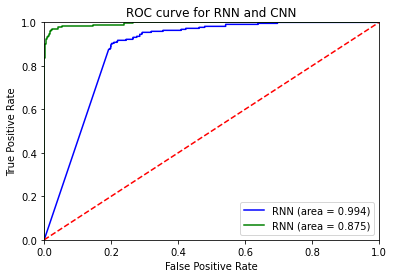

In [78]:
#  ROC
plt.title('ROC curve for RNN and CNN')
plt.plot(cnn_fpr, cnn_tpr, 'b', label = 'RNN (area = {:.3f})'.format(rnn_auc))
plt.plot(rnn_fpr,rnn_tpr,'g',label='RNN (area = {:.3f})'.format(cnn_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()